# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip install tensorflow-tensorboard
!pip install --upgrade numpy
!pip install --upgrade ipython
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
n_agents = len(env_info.agents)
print('Number of agents:', n_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(n_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(n_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [2]:
import torch
from unityagents import UnityEnvironment
import numpy as np
from collections import deque

from agent import Agent


env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

# Get default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Get state and action spaces
env_info = env.reset(train_mode=True)[brain_name]
state_size = env_info.vector_observations.shape[1]
action_size = brain.vector_action_space_size
n_agents = len(env_info.agents)

print('State size: ', state_size)
print('Action size: ', action_size)
print('Number of agents: ', n_agents)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


State size:  24
Action size:  2
Number of agents:  2


In [ ]:
def ddpg(n_episodes=2000, t_max=3000):
    """Deep Determinitic Policy Gradient.

    Params
    ======
        env: unity environment object
        brain_name (string): brain name of initialized environment
        agent: initialized agent object
        n_episodes (int): maximum number of training episodes
        t_max (int): maximum timesteps in episode
    """
    
    scores = []
    scores_window = deque(maxlen=100)
    best_score = -np.Inf
    
    for episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros(n_agents)
        
        for _ in range(1, t_max):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state[0], action[0], reward[0], next_state[0], done[0], learn=True)
            agent.step(state[1], action[1], reward[1], next_state[1], done[1], learn=False)
            score += reward
            state = next_state
            if np.any(done):
                break

        # Max score
        max_score = np.max(score)
        scores_window.append(max_score)
        scores.append(max_score)

        print('\rEpisode {}\tAverage Score: {:.2f}\tReal Score: {:.2f}'.format(episode, np.mean(scores_window), max_score), end="")
        
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        
        if np.mean(scores_window) > best_score:
            torch.save(agent.actor_local.state_dict(), 'actor_chkpt.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_chkpt.pth')
            best_score = np.mean(scores_window)
        
        if np.mean(scores_window)>=0.5:
            print('\nAgent solved the environment in {:d} episodes!\tAverage Score: {:.2f}'.format(episode-100, np.mean(scores_window)))
            break
            
    return scores

In [3]:
agent = Agent(state_size, action_size, n_agents, buffer_size=int(1e7), batch_size=128, gamma=.99, tau=1e-2,lr_a=1e-4, 
              lr_c=1e-3, weight_decay=0.0, update_local=1, n_updates=1, random_seed=1)

scores = ddpg(n_episodes=2000)

Episode 100	Average Score: 0.01	Current Score: 0.00
Episode 200	Average Score: 0.04	Current Score: 0.00
Episode 300	Average Score: 0.08	Current Score: 0.10
Episode 400	Average Score: 0.18	Current Score: 1.40
Episode 478	Average Score: 0.50	Current Score: 2.60
Environment solved in 378 episodes!	Average Score: 0.50


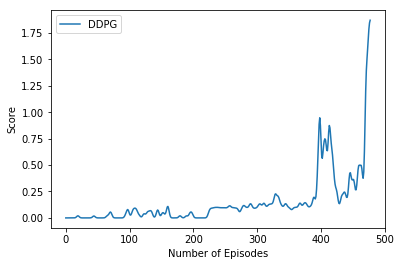

In [4]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure()
scores_smoothed = gaussian_filter1d(scores, sigma=2)
plt.plot(np.arange(len(scores)), scores_smoothed, label='DDPG')
plt.ylabel('Score')
plt.xlabel('Number of Episodes')
plt.legend()
plt.show()

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 